<a href="https://colab.research.google.com/github/RyuseiHoshino/PJ_practice2/blob/main/%E6%96%BD%E7%AD%96L.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 【最終版】顧客離反の特徴分析 ###

[1/8] データの読み込み...
...全データの読み込みが完了しました。

[3/3] データの前処理と結合を開始します...
...データの前処理と結合が完了しました。

[3/8] 集計ベースの特徴量作成...

[4/8] 特徴量エンジニアリング...

[5/8] 離反顧客の定義...

[6/8] 分析用データセットの最終準備...

[7/8] 不均衡データのサンプリングとモデル学習...
[LightGBM] [Info] Number of positive: 65710, number of negative: 65660
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3098
[LightGBM] [Info] Number of data points in the train set: 131370, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500190 -> initscore=0.000761
[LightGBM] [Info] Start training from score 0.000761


<ipython-input-3-3739776580>:150: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-3739776580>:150: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-3739776580>:150: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()



[8/8] 特徴量重要度の可視化...


<ipython-input-3-3739776580>:150: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-3739776580>:150: UserWarning: Glyph 24500 (\N{CJK UNIFIED IDEOGRAPH-5FB4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-3739776580>:150: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-3739776580>:150: UserWarning: Glyph 12304 (\N{LEFT BLACK LENTICULAR BRACKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-3739776580>:150: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-3739776580>:150: UserWarning: Glyph 32066 (\N{CJK UNIFIED IDEOGRAPH-7D42}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-3739776580>:150: UserWarning: Glyph 29256 (\N{CJK UNIFIED IDEOGRAPH-7248}) missing from font(s) De

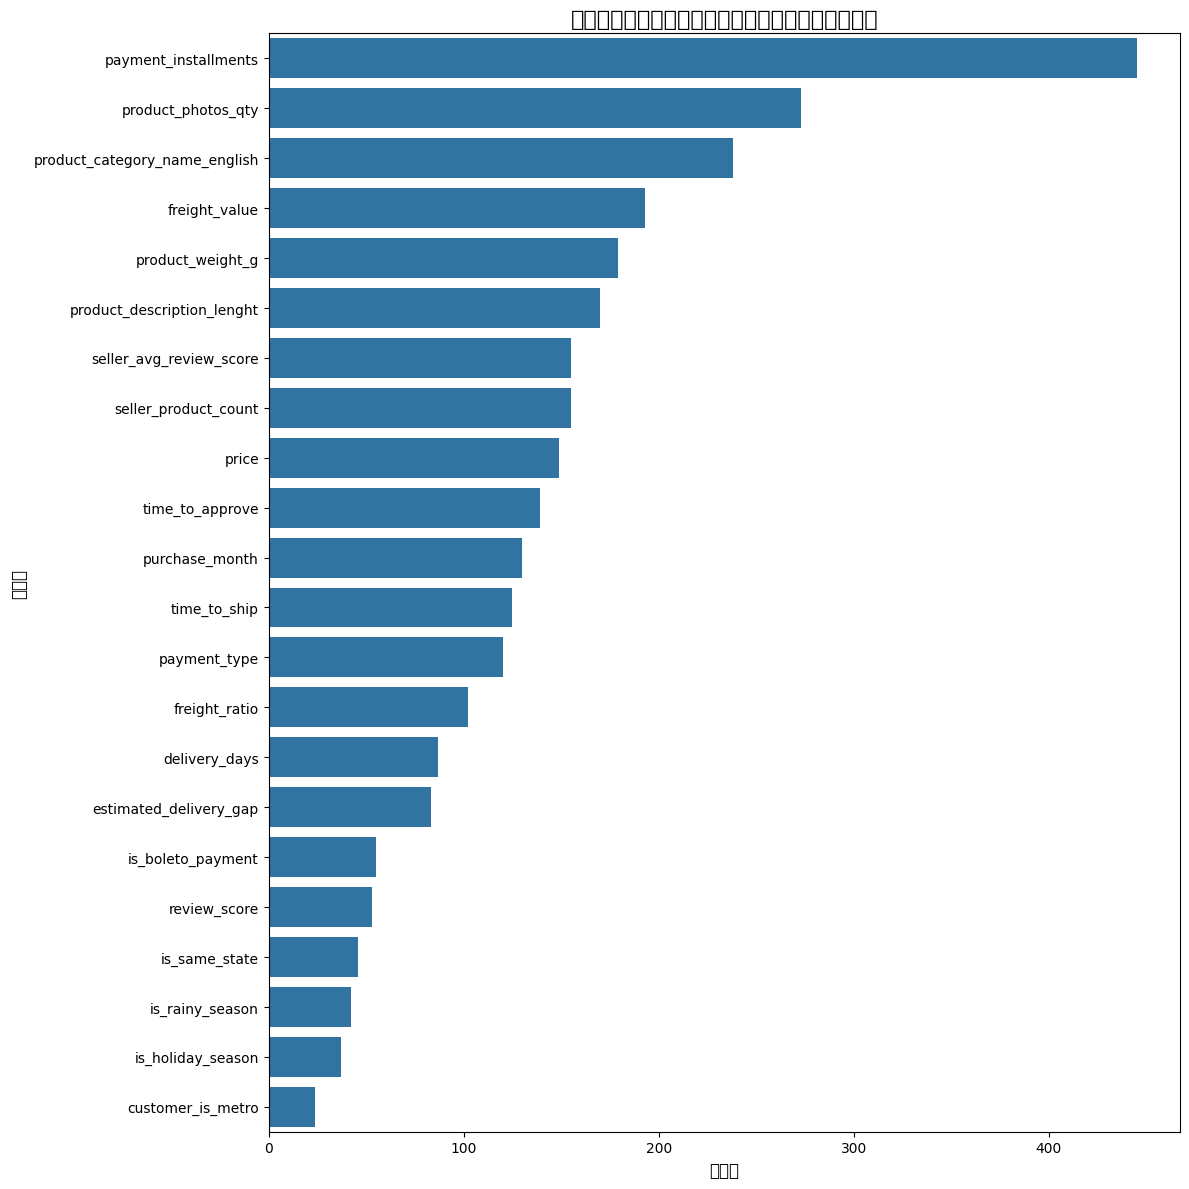


--- 分析完了 ---
                          feature  importance
0            payment_installments         445
1              product_photos_qty         273
2   product_category_name_english         238
3                   freight_value         193
4                product_weight_g         179
5      product_description_lenght         170
6         seller_avg_review_score         155
7            seller_product_count         155
8                           price         149
9                 time_to_approve         139
10                 purchase_month         130
11                   time_to_ship         125
12                   payment_type         120
13                  freight_ratio         102
14                  delivery_days          87
15         estimated_delivery_gap          83
16              is_boleto_payment          55
17                   review_score          53
18                  is_same_state          46
19                is_rainy_season          42
20              is_h

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from math import radians, sin, cos, sqrt, atan2

# Matplotlibの日本語フォント設定（Colab用）
# !apt-get -y install fonts-ipafont-gothic
# import matplotlib.font_manager as fm
# font_path = '/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf'
# prop = fm.FontProperties(fname=font_path)
# plt.rcParams['font.family'] = prop.get_name()

print("### 【最終版】顧客離反の特徴分析 ###")

# 1. データの読み込み
print("\n[1/8] データの読み込み...")
try:
    # ご提示のGoogle Driveパスから各CSVファイルを読み込みます
    base_path = "/content/drive/Shareddrives/000_共有/B00_◯◯サクセス本部/B01_エンプロイーサクセス部/04_人事/06_研修・育成/01_新人研修/2025/07_PJ実践/02_資料/PJ実践②/data/"
    item_df = pd.read_csv(base_path + "olist_order_items_dataset.csv")
    cust_df = pd.read_csv(base_path + "olist_customers_dataset.csv")
    geoloc_df = pd.read_csv(base_path + "olist_geolocation_dataset.csv")
    pay_df = pd.read_csv(base_path + "olist_order_payments_dataset.csv")
    rvw_df = pd.read_csv(base_path + "olist_order_reviews_dataset.csv")
    orders_df = pd.read_csv(base_path + "olist_orders_dataset.csv")
    prod_df = pd.read_csv(base_path + "olist_products_dataset.csv")
    sell_df = pd.read_csv(base_path + "olist_sellers_dataset.csv")
    cate_df = pd.read_csv(base_path + "product_category_name_translation.csv")
    print("...全データの読み込みが完了しました。")
except FileNotFoundError:
    print("エラー: ファイルが見つかりません。")
    print("Google Driveのファイルパスが正しいか、ファイルが存在するか確認してください。")
    exit()

# ===================================================================
# 3. データの前処理と結合
# ===================================================================
print("\n[3/3] データの前処理と結合を開始します...")
# タイムスタンプをdatetime型に変換
for col in ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']:
    orders_df[col] = pd.to_datetime(orders_df[col], errors='coerce')

# 分析対象を配達済みの注文に絞り込み、不要な欠損値を持つ行を削除
orders_df = orders_df[orders_df['order_status'] == 'delivered'].copy()
orders_df.dropna(subset=['order_purchase_timestamp', 'order_delivered_customer_date'], inplace=True)

# 全テーブルをマージして、一つの大きなデータフレームを作成
df = pd.merge(orders_df, item_df, on='order_id', how='left')
df = pd.merge(df, pay_df, on='order_id', how='left')
df = pd.merge(df, rvw_df, on='order_id', how='left')
df = pd.merge(df, prod_df, on='product_id', how='left')
df = pd.merge(df, cust_df, on='customer_id', how='left')
df = pd.merge(df, sell_df, on='seller_id', how='left')
df = pd.merge(df, cate_df, on='product_category_name', how='left')

print("...データの前処理と結合が完了しました。")
# 3. 集計ベースの特徴量作成
print("\n[3/8] 集計ベースの特徴量作成...")
seller_stats = df.groupby('seller_id').agg(
    seller_avg_review_score=('review_score', 'mean'),
    seller_product_count=('product_id', 'nunique')
).reset_index()
df = pd.merge(df, seller_stats, on='seller_id', how='left')

# 4. 特徴量エンジニアリング
print("\n[4/8] 特徴量エンジニアリング...")
# 時間関連
df['delivery_days'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
df['estimated_delivery_gap'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days
df['time_to_approve'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600
df['time_to_ship'] = (df['order_delivered_carrier_date'] - df['order_approved_at']).dt.total_seconds() / (3600 * 24)

# 季節関連
df['purchase_month'] = df['order_purchase_timestamp'].dt.month
# ブラジル南東部の雨期（夏）を12月～3月と仮定
df['is_rainy_season'] = df['purchase_month'].isin([12, 1, 2, 3]).astype(int)
# ブラックフライデーとクリスマスをホリデーシーズンと仮定
df['is_holiday_season'] = df['purchase_month'].isin([11, 12]).astype(int)

# 地域関連
df['is_same_state'] = (df['customer_state'] == df['seller_state']).astype(int)
metro_states = ['SP', 'RJ', 'MG']
df['customer_is_metro'] = df['customer_state'].isin(metro_states).astype(int)

# 支払い関連
df['is_boleto_payment'] = (df['payment_type'] == 'boleto').astype(int)
df['freight_ratio'] = df['freight_value'] / df['price']

# 5. 離反の定義
print("\n[5/8] 離反顧客の定義...")
purchase_counts = df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
purchase_counts.columns = ['customer_unique_id', 'purchase_count']
df = pd.merge(df, purchase_counts, on='customer_unique_id')
df['churned'] = (df['purchase_count'] == 1).astype(int)

# 6. 分析用データセットの最終準備
print("\n[6/8] 分析用データセットの最終準備...")
df.drop_duplicates(subset=['order_id', 'product_id'], inplace=True) # 1注文1商品に集約（簡易化）

features = [
    'review_score', 'price', 'freight_value', 'payment_installments',
    'product_description_lenght', 'product_photos_qty', 'product_weight_g',
    'delivery_days', 'estimated_delivery_gap', 'time_to_approve', 'time_to_ship',
    'purchase_month', 'is_rainy_season', 'is_holiday_season',
    'is_same_state', 'customer_is_metro',
    'is_boleto_payment', 'freight_ratio',
    'seller_avg_review_score', 'seller_product_count',
    'payment_type', 'product_category_name_english'
]
target = 'churned'

# カテゴリ変数をエンコーディング
for col in ['payment_type', 'product_category_name_english']:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])

# 無限大をNaNに置き換え、欠損値を-1で補完
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df[features] = df[features].fillna(-1)

X = df[features]
y = df[target]

# 7. 不均衡データのサンプリング (SMOTE) & モデル学習
print("\n[7/8] 不均衡データのサンプリングとモデル学習...")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
lgb_clf = lgb.LGBMClassifier(random_state=42)
lgb_clf.fit(X_train, y_train)

# 8. 特徴量重要度の可視化
print("\n[8/8] 特徴量重要度の可視化...")
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': lgb_clf.feature_importances_})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 12))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('【最終版】顧客離反に影響を与える特徴量の重要度', fontname="IPAGothic", fontsize=16)
plt.xlabel('重要度', fontname="IPAGothic", fontsize=12)
plt.ylabel('特徴量', fontname="IPAGothic", fontsize=12)
plt.yticks(fontname="IPAGothic")
plt.tight_layout()
plt.show()

print("\n--- 分析完了 ---")
print(feature_importances.reset_index(drop=True))

### モデル予測性能評価 ###
Accuracy (正解率): 0.93
Precision (適合率): 0.88
Recall (再現率): 0.99
F1 Score: 0.93
AUC: 0.97


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23455 (\N{CJK UNIFIED IDEOGRAPH-5B9F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38555 (\N{CJK UNIFIED IDEOGRAPH-969B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38626 (\N{CJK UNIFIED IDEOGRAPH-96E2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21453 (\N{CJK UNIFIED IDEOGRAPH-53CD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_f

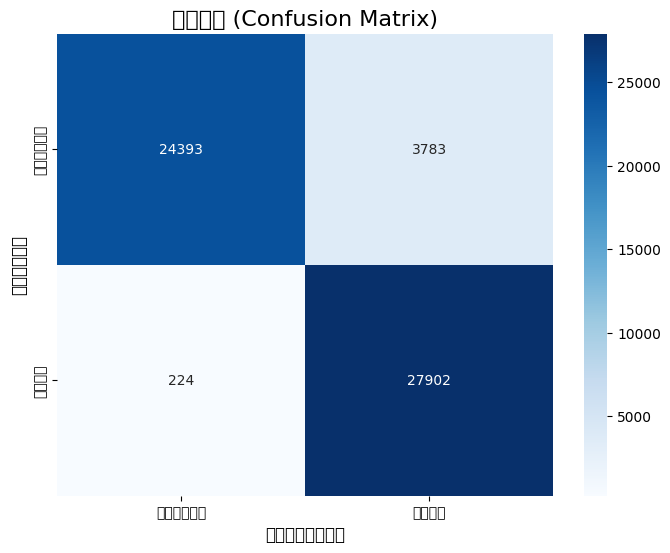


--- 分類レポート ---
              precision    recall  f1-score   support

    リピート (0)       0.99      0.87      0.92     28176
      離反 (1)       0.88      0.99      0.93     28126

    accuracy                           0.93     56302
   macro avg       0.94      0.93      0.93     56302
weighted avg       0.94      0.93      0.93     56302



In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 前のステップで学習済みのモデル(lgb_clf)とテストデータ(X_test, y_test)を使用
y_pred = lgb_clf.predict(X_test)
y_pred_proba = lgb_clf.predict_proba(X_test)[:, 1]

# 1. 主要指標の計算
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print("### モデル予測性能評価 ###")
print(f"Accuracy (正解率): {accuracy:.2f}")
print(f"Precision (適合率): {precision:.2f}")
print(f"Recall (再現率): {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC: {auc:.2f}")

# 2. 混同行列の可視化
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['リピート予測', '離反予測'],
            yticklabels=['実際リピート', '実際離反'])
plt.title('混同行列 (Confusion Matrix)', fontname="IPAGothic", fontsize=16)
plt.ylabel('実際のクラス', fontname="IPAGothic", fontsize=12)
plt.xlabel('予測されたクラス', fontname="IPAGothic", fontsize=12)
plt.yticks(fontname="IPAGothic")
plt.xticks(fontname="IPAGothic")
plt.show()

# 3. 分類レポートの表示
class_report = classification_report(y_test, y_pred, target_names=['リピート (0)', '離反 (1)'])
print("\n--- 分類レポート ---")
print(class_report)